In [26]:
import pandas as pd
import torch
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModel

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
!cp /kaggle/input/farstail-nli-task/train.py /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
!git clone https://github.com/dml-qom/FarsTail data/FarsTail

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
fatal: destination path 'data/FarsTail' already exists and is not an empty directory.


In [30]:
from IPython import display
def rtl_print(outputs, font_size="15px", n_to_br=False):
    outputs = outputs if isinstance(outputs, list) else [outputs] 
    if n_to_br:
        outputs = [output.replace('\n', '') for output in outputs]
        
    outputs = [f'{output}' for output in outputs]
    display.display(display.HTML(' '.join(outputs)))


In [31]:


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


def compute_loss(y, predictions, loss):
    # loss
    # binarize predictions from predictions (outputs = 1 if p>0.5 else 0)
    outputs = torch.argmax(predictions, axis=1)
    # metrics with accuracy, precision, recall, f1
    accuracy = accuracy_score(y.cpu(), outputs.cpu())
    precision, recall, f1 = [metric(y.cpu(), outputs.cpu(), average='micro') for metric in [precision_score, recall_score, f1_score]]
    return loss, accuracy, precision, recall, f1
    
def evaluate_loader(loader, model, criterion, device):
    # compute loss and accuracy for that loader
    metrics = {
        "loss": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0,
    }
    with torch.no_grad():
        # loop over examples of loader
        for i, data in enumerate(loader):

            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"].to(device)
            now_batch_size = label_id.size(0)
            logits, probs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, label_id)
            loss, accuracy, precision, recall, f1 = compute_loss(label_id, logits, loss)
            # sum up metrics in dict
            metrics["loss"] += loss.item()
            metrics["accuracy"] += accuracy
            metrics["precision"] += precision
            metrics["recall"] += recall
            metrics["f1"] += f1
        # normalize all values
        for k in metrics.keys():
            metrics[k] /= len(loader)
        return metrics

def show_cm(model, loader, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for i, data in enumerate(loader):
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"].to(device)
            now_batch_size = label_id.size(0)
            logits, probs = model(input_ids, attention_mask, token_type_ids)
            outputs = torch.argmax(logits, axis=1)
            y_true.extend(label_id.tolist())
            y_pred.extend(outputs.tolist())
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [32]:
train_df = pd.read_csv('./data/FarsTail/data/Train-word.csv', sep='\t')
val_df = pd.read_csv('./data/FarsTail/data/Val-word.csv', sep='\t')
test_df = pd.read_csv('./data/FarsTail/data/Test-word.csv', sep='\t')

In [33]:
train_df.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['label_id'] = label_encoder.fit_transform(train_df['label'])
val_df['label_id'] = label_encoder.transform(val_df['label'])
test_df['label_id'] = label_encoder.transform(test_df['label'])

In [35]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = 50

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # x = torch.tensor(row['text'], dtype=torch.float32)
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        label = row["label"]
        label_id = row["label_id"]
        # text = f"{self.tokenizer.cls_token} {premise} {self.tokenizer.sep_token} {hypothesis} {self.tokenizer.sep_token}"
        # Tokenize inputs
        encoded_inputs = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoded_inputs["input_ids"].squeeze()
        attention_mask = encoded_inputs["attention_mask"].squeeze()
        token_type_id = encoded_inputs["token_type_ids"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_id,
            "label": label,
            "label_id": torch.tensor(label_id, dtype=torch.long),
        }

attention mask  
https://huggingface.co/transformers/v3.2.0/glossary.html#attention-mask  
token type id  
https://huggingface.co/transformers/v3.2.0/glossary.html#token-type-ids  

In [36]:

# config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
# model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
# model = model.to(device)



In [37]:
from multiprocessing import cpu_count

train_dataset = Dataset(train_df, tokenizer)
val_dataset = Dataset(val_df, tokenizer)
test_dataset = Dataset(test_df, tokenizer)


batch_size = 32
num_workers = cpu_count() - 2
pin_memory = True if device == "cuda" else False
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [38]:
# from transformers import *
# from utils.utils import build_batch


class BertNLIModel(nn.Module):
    def __init__(
        self,
        label_num=3,
        reinit_num=0,
        encoder_layer=12,
        freeze_layers=True,
    ):
        super(BertNLIModel, self).__init__()
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.config = AutoConfig.from_pretrained(
            "HooshvareLab/bert-base-parsbert-uncased"
        )
        # self.tokenizer = AutoTokenizer.from_pretrained(
        #     "HooshvareLab/bert-base-parsbert-uncased"
        # )
        self.bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
        self.bert.encoder.layer = self.bert.encoder.layer[:encoder_layer]

        self.num_hidden_layers = self.config.num_hidden_layers
        self.vdim = self.config.hidden_size
        self.encoder_layer = encoder_layer

        self.nli_head1 = nn.Linear(self.vdim, 250)
        self.nli_head2 = nn.Linear(250, label_num)
        self.sm = nn.Softmax(dim=1)
        self.reinit(freeze=freeze_layers)

    def reinit(self, freeze):
        if freeze:
            for _, pp in self.bert.named_parameters():
                pp.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        cls_vecs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )[1]

        logits = self.nli_head1(cls_vecs)
        logits = self.nli_head2(logits)
        probs = self.sm(logits)

        torch.cuda.empty_cache()  # releases all unoccupied cached memory

        return logits, probs

    def _get_name(self):
        return f"{super()._get_name()}-{self.encoder_layer}"

    def __str__(self) -> str:
        return f"BertNLIModel-Encoder-{self.encoder_layer}"

    def __repr__(self):
        return f"BertNLIModel-Encoder-{self.encoder_layer}"

In [39]:
data = next(iter(train_loader))

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)
label_id = data['label_id'].to(device)

In [40]:
from train import train
from easydict import EasyDict

dataset = EasyDict(
    {
        "train": train_dataset,
        "val": test_dataset,
        "test": test_dataset,
    }
)
data_loader = EasyDict(
    {
        "train": train_loader,
        "val": test_loader,
        "test": test_loader,
    }
)

In [41]:
model = BertNLIModel(label_num=3, encoder_layer=1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-1-optimizer-AdamW-loss-CrossEntropyLoss.pth exist


In [42]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.0983108063133395
accuracy 0.3414723032069971
precision 0.3414723032069971
recall 0.3414723032069971
f1 0.3414723032069971
[[  0   0 510]
 [  1   0 518]
 [  1   0 534]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-2-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[11s] Epoch 1 loss : 1.12255108 acc: 33.29 val: 1.10472958 acc: 33.38%


### BETTER NET STATE ###
[11s] Epoch 2 loss : 1.11329755 acc: 33.71 val: 1.10127426 acc: 34.46%


### BETTER NET STATE ###
[11s] Epoch 3 loss : 1.10851768 acc: 33.73 val: 1.10095016 acc: 34.02%


[11s] Epoch 4 loss : 1.10935958 acc: 33.54 val: 1.10322757 acc: 32.74%


[11s] Epoch 5 loss : 1.10647186 acc: 33.49 val: 1.10262004 acc: 33.31%


### BETTER NET STATE ###
[11s] Epoch 6 loss : 1.10539551 acc: 33.14 val: 1.09878529 acc: 36.25%


[11s] Epoch 7 loss : 1.09985923 acc: 34.33 val: 1.09905382 acc: 35.04%


[11s] Epoch 8 loss : 1.09942073 acc: 33.34 val: 1.10089607 acc: 34.21%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[11s] Epoch 15 loss : 1.09887314 acc: 33.63 val: 1.09930711 acc: 34.21%


[11s] Epoch 16 loss : 1.09884668 acc: 33.09 val: 1.09846599 acc: 33.25%


[12s] Epoch 17 loss : 1.09851531 acc: 34.13 val: 1.09833311 acc: 36.7%


[12s] Epoch 18 loss : 1.09875063 acc: 35.09 val: 1.09917055 acc: 33.76%


### BETTER NET STATE ###
[11s] Epoch 19 loss : 1.09977586 acc: 33.67 val: 1.09740398 acc: 36.19%


[11s] Epoch 20 loss : 1.09953810 acc: 33.03 val: 1.09767834 acc: 34.4%


[11s] Epoch 21 loss : 1.09884257 acc: 34.8 val: 1.09859339 acc: 34.21%


[11s] Epoch 22 loss : 1.09821118 acc: 33.87 val: 1.09879768 acc: 34.27%


[11s] Epoch 23 loss : 1.09860221 acc: 34.29 val: 1.09808771 acc: 34.65%


### BETTER NET STATE ###
[11s] Epoch 24 loss : 1.09810590 acc: 34.03 val: 1.09680914 acc: 36.38%


[11s] Epoch 25 loss : 1.09830013 acc: 34.47 val: 1.09776314 acc: 34.4%


[11s] Epoch 26 loss : 1.09921683 acc: 34.24 val: 1.09780974 acc: 34.34%


[11s] Epoch 27 loss : 1.09860872 acc: 34.0 val: 1.10249352 acc: 33.18%


[11s] Epoch 28 loss : 1.09835863 acc: 34.8 val: 1.09747893 acc: 35.93%


[11s] Epoch 29 loss : 1.09892618 acc: 33.76 val: 1.09778422 acc: 35.04%


[11s] Epoch 30 loss : 1.09872539 acc: 33.99 val: 1.09943821 acc: 33.18%


### BETTER NET STATE ###
[11s] Epoch 31 loss : 1.09825922 acc: 34.11 val: 1.09653366 acc: 36.19%


[11s] Epoch 32 loss : 1.09831544 acc: 33.78 val: 1.09763245 acc: 34.46%


[11s] Epoch 33 loss : 1.09855333 acc: 35.01 val: 1.09669134 acc: 35.93%


[11s] Epoch 34 loss : 1.09880379 acc: 35.26 val: 1.10142328 acc: 32.61%


[11s] Epoch 35 loss : 1.09816533 acc: 34.95 val: 1.09702355 acc: 37.6%


### BETTER NET STATE ###
[11s] Epoch 36 loss : 1.09726073 acc: 35.31 val: 1.09591448 acc: 36.51%


[11s] Epoch 37 loss : 1.09869614 acc: 34.39 val: 1.09626226 acc: 35.42%


[11s] Epoch 38 loss : 1.09825986 acc: 34.17 val: 1.09662691 acc: 35.1%


[11s] Epoch 39 loss : 1.09771410 acc: 34.66 val: 1.09677923 acc: 36.64%


### BETTER NET STATE ###
[11s] Epoch 40 loss : 1.09883126 acc: 34.51 val: 1.09565069 acc: 38.55%


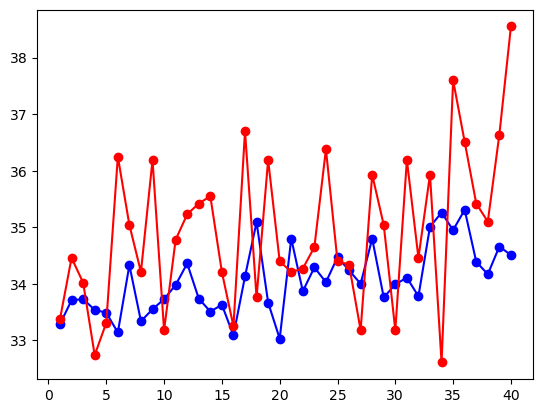

In [52]:
model = BertNLIModel(label_num=3, encoder_layer=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [53]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.0949550331855307
accuracy 0.3855685131195335
precision 0.3855685131195335
recall 0.3855685131195335
f1 0.3855685131195335
[[  0 301 209]
 [  0 329 190]
 [  0 261 274]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-3-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[11s] Epoch 1 loss : 1.11918516 acc: 33.34 val: 1.10940324 acc: 33.44%


### BETTER NET STATE ###
[11s] Epoch 2 loss : 1.11921005 acc: 33.47 val: 1.10025594 acc: 33.7%


[11s] Epoch 3 loss : 1.11159660 acc: 33.41 val: 1.10674296 acc: 32.74%


[11s] Epoch 4 loss : 1.10702841 acc: 35.05 val: 1.11681010 acc: 34.27%


### BETTER NET STATE ###
[11s] Epoch 5 loss : 1.10475439 acc: 34.71 val: 1.10012844 acc: 35.68%


### BETTER NET STATE ###
[12s] Epoch 6 loss : 1.10087688 acc: 34.11 val: 1.09867725 acc: 37.72%


### BETTER NET STATE ###
[11s] Epoch 7 loss : 1.09941169 acc: 34.98 val: 1.09534196 acc: 37.08%


[11s] Epoch 8 loss : 1.09928015 acc: 34.49 val: 1.09611897 acc: 35.93%


[11s] Epoch 9 loss : 1.09802467 acc: 35.3 val: 1.09874764 acc: 32.8%


[11s] Epoch 10 loss : 1.09715498 acc: 35.39 val: 1.09535694 acc: 36.06%


### BETTER NET STATE ###
[11s] Epoch 11 loss : 1.09701696 acc: 35.48 val: 1.09459658 acc: 36.64%


[11s] Epoch 12 loss : 1.09680421 acc: 35.15 val: 1.09621186 acc: 34.97%


[11s] Epoch 13 loss : 1.09677360 acc: 35.68 val: 1.09802656 acc: 35.61%


[11s] Epoch 14 loss : 1.09720010 acc: 35.7 val: 1.09548399 acc: 36.19%


[11s] Epoch 15 loss : 1.09705735 acc: 36.04 val: 1.09461683 acc: 36.45%


[11s] Epoch 16 loss : 1.09759317 acc: 35.16 val: 1.09592475 acc: 35.93%


[11s] Epoch 17 loss : 1.09626757 acc: 35.81 val: 1.10397627 acc: 33.63%


### BETTER NET STATE ###
[11s] Epoch 18 loss : 1.09719112 acc: 35.24 val: 1.09372775 acc: 36.76%


[11s] Epoch 19 loss : 1.09638603 acc: 36.27 val: 1.09457797 acc: 37.4%


### BETTER NET STATE ###
[12s] Epoch 20 loss : 1.09591405 acc: 35.89 val: 1.09322780 acc: 36.57%


[11s] Epoch 21 loss : 1.09482000 acc: 36.12 val: 1.10218940 acc: 33.31%


### BETTER NET STATE ###
[11s] Epoch 22 loss : 1.09662993 acc: 35.96 val: 1.09202584 acc: 37.08%


### BETTER NET STATE ###
[11s] Epoch 23 loss : 1.09532878 acc: 36.21 val: 1.09200767 acc: 37.85%


[11s] Epoch 24 loss : 1.09558312 acc: 35.96 val: 1.09202722 acc: 37.28%


[11s] Epoch 25 loss : 1.09704607 acc: 35.31 val: 1.09204472 acc: 38.36%


### BETTER NET STATE ###
[11s] Epoch 26 loss : 1.09576156 acc: 35.6 val: 1.09149492 acc: 37.66%


[11s] Epoch 27 loss : 1.09542115 acc: 36.44 val: 1.09187596 acc: 39.45%


[12s] Epoch 28 loss : 1.09456442 acc: 36.08 val: 1.09198110 acc: 38.43%


### BETTER NET STATE ###
[11s] Epoch 29 loss : 1.09370231 acc: 37.06 val: 1.09091021 acc: 38.17%


[11s] Epoch 30 loss : 1.09450894 acc: 36.11 val: 1.09441803 acc: 36.19%


[11s] Epoch 31 loss : 1.09489079 acc: 36.11 val: 1.09108254 acc: 37.47%


### BETTER NET STATE ###
[11s] Epoch 32 loss : 1.09416905 acc: 36.12 val: 1.09027421 acc: 38.17%


[11s] Epoch 33 loss : 1.09477090 acc: 35.77 val: 1.09044423 acc: 38.11%


[11s] Epoch 34 loss : 1.09517074 acc: 36.11 val: 1.09036977 acc: 38.11%


[11s] Epoch 35 loss : 1.09316256 acc: 36.96 val: 1.09463695 acc: 36.89%


### BETTER NET STATE ###
[11s] Epoch 36 loss : 1.09333467 acc: 37.36 val: 1.08923452 acc: 38.04%


[11s] Epoch 37 loss : 1.09356914 acc: 36.27 val: 1.09230155 acc: 35.61%


[11s] Epoch 38 loss : 1.09305588 acc: 37.14 val: 1.08947269 acc: 38.3%


[12s] Epoch 39 loss : 1.09440581 acc: 35.99 val: 1.09555712 acc: 35.42%


[11s] Epoch 40 loss : 1.09407008 acc: 36.84 val: 1.09187404 acc: 37.28%


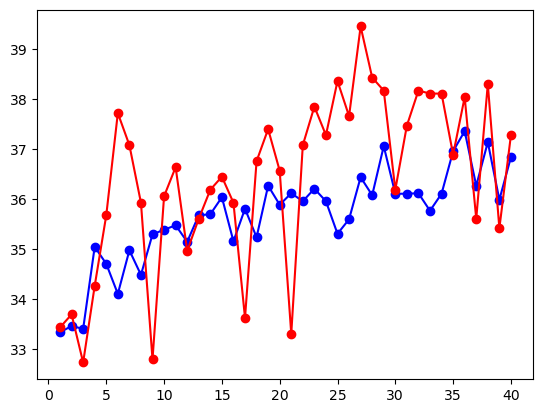

In [44]:
model = BertNLIModel(label_num=3, encoder_layer=3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [45]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.0911931310381209
accuracy 0.3728134110787172
precision 0.3728134110787172
recall 0.3728134110787172
f1 0.3728134110787172
[[340   1 169]
 [348   1 170]
 [293   0 242]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-4-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[13s] Epoch 1 loss : 1.06558727 acc: 42.62 val: 1.05414929 acc: 44.5%


### BETTER NET STATE ###
[13s] Epoch 2 loss : 1.05893136 acc: 42.9 val: 1.03637315 acc: 44.57%


### BETTER NET STATE ###
[13s] Epoch 3 loss : 1.04130412 acc: 45.47 val: 1.01650100 acc: 46.68%


[13s] Epoch 4 loss : 1.04079827 acc: 45.13 val: 1.01804345 acc: 46.1%


[13s] Epoch 5 loss : 1.04630197 acc: 44.03 val: 1.10197514 acc: 40.98%


[13s] Epoch 6 loss : 1.04626752 acc: 45.33 val: 1.08137711 acc: 40.22%


[13s] Epoch 7 loss : 1.03219395 acc: 45.64 val: 1.03563262 acc: 44.88%


### BETTER NET STATE ###
[13s] Epoch 8 loss : 1.03289586 acc: 45.69 val: 0.99749414 acc: 49.55%


[13s] Epoch 9 loss : 1.03213820 acc: 46.04 val: 1.02001079 acc: 46.68%


### BETTER NET STATE ###
[13s] Epoch 10 loss : 1.02713813 acc: 46.06 val: 0.99601456 acc: 49.49%


[13s] Epoch 11 loss : 1.03507031 acc: 45.73 val: 1.02003249 acc: 46.68%


[13s] Epoch 12 loss : 1.02596795 acc: 46.32 val: 1.06990006 acc: 42.65%


### BETTER NET STATE ###
[13s] Epoch 13 loss : 1.02312766 acc: 45.91 val: 0.99222794 acc: 49.3%


[13s] Epoch 14 loss : 1.02895527 acc: 46.68 val: 1.01445476 acc: 47.12%


[13s] Epoch 15 loss : 1.02696382 acc: 46.35 val: 1.00794337 acc: 47.51%


[13s] Epoch 16 loss : 1.02896186 acc: 45.57 val: 0.99296304 acc: 50.19%


[13s] Epoch 17 loss : 1.02654406 acc: 46.04 val: 0.99792982 acc: 48.85%


[13s] Epoch 18 loss : 1.02580055 acc: 46.42 val: 0.99322521 acc: 51.09%


[13s] Epoch 19 loss : 1.02144242 acc: 46.85 val: 0.99441117 acc: 50.77%


[13s] Epoch 20 loss : 1.02251669 acc: 46.74 val: 1.00044936 acc: 48.53%


### BETTER NET STATE ###
[13s] Epoch 21 loss : 1.02503272 acc: 46.42 val: 0.98786922 acc: 50.06%


[13s] Epoch 22 loss : 1.02504785 acc: 46.34 val: 1.01734039 acc: 46.61%


[13s] Epoch 23 loss : 1.01713255 acc: 47.18 val: 1.00350945 acc: 48.27%


[13s] Epoch 24 loss : 1.02063996 acc: 47.4 val: 1.01779762 acc: 45.91%


[13s] Epoch 25 loss : 1.02164262 acc: 47.18 val: 1.00045612 acc: 48.08%


[13s] Epoch 26 loss : 1.02333022 acc: 46.68 val: 1.01266994 acc: 46.16%


[13s] Epoch 27 loss : 1.01840333 acc: 46.79 val: 0.98864109 acc: 50.0%


[13s] Epoch 28 loss : 1.02187605 acc: 47.01 val: 1.03230459 acc: 45.46%


[13s] Epoch 29 loss : 1.01639671 acc: 47.55 val: 1.06273955 acc: 42.2%


[13s] Epoch 30 loss : 1.02862690 acc: 45.61 val: 0.99065255 acc: 50.51%


[13s] Epoch 31 loss : 1.02533833 acc: 46.65 val: 0.98867828 acc: 49.3%


### BETTER NET STATE ###
[13s] Epoch 32 loss : 1.01351112 acc: 47.52 val: 0.98365795 acc: 51.53%


[13s] Epoch 33 loss : 1.01943340 acc: 47.22 val: 1.01876299 acc: 46.1%


### BETTER NET STATE ###
[13s] Epoch 34 loss : 1.01661520 acc: 46.9 val: 0.98364497 acc: 50.51%


[13s] Epoch 35 loss : 1.01869894 acc: 47.19 val: 0.98583517 acc: 51.21%


[13s] Epoch 36 loss : 1.01880059 acc: 46.97 val: 1.00289165 acc: 48.66%


[13s] Epoch 37 loss : 1.01636722 acc: 47.84 val: 0.99085779 acc: 49.94%


[13s] Epoch 38 loss : 1.02048248 acc: 46.99 val: 0.99683288 acc: 48.72%


### BETTER NET STATE ###
[13s] Epoch 39 loss : 1.02112432 acc: 46.81 val: 0.98350495 acc: 50.32%


[13s] Epoch 40 loss : 1.01395007 acc: 47.76 val: 1.02727274 acc: 44.76%


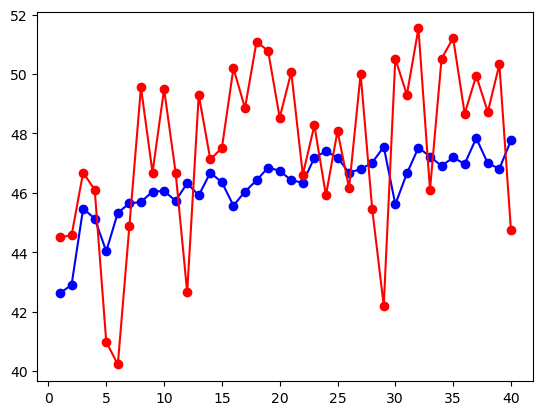

In [46]:
model = BertNLIModel(label_num=3, encoder_layer=4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [47]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.0265956156107845
accuracy 0.4475218658892128
precision 0.4475218658892128
recall 0.4475218658892128
f1 0.4475218658892128
[[ 22 420  68]
 [ 23 471  25]
 [ 40 288 207]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-5-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[14s] Epoch 1 loss : 1.04320351 acc: 44.56 val: 1.03643149 acc: 48.27%


### BETTER NET STATE ###
[14s] Epoch 2 loss : 1.02724838 acc: 46.02 val: 0.98027656 acc: 49.68%


### BETTER NET STATE ###
[14s] Epoch 3 loss : 1.00949071 acc: 47.95 val: 0.97656363 acc: 49.17%


### BETTER NET STATE ###
[14s] Epoch 4 loss : 1.00889155 acc: 47.59 val: 0.97190989 acc: 52.43%


[14s] Epoch 5 loss : 1.00554926 acc: 48.39 val: 0.97955226 acc: 49.17%


### BETTER NET STATE ###
[14s] Epoch 6 loss : 1.00472589 acc: 47.66 val: 0.96191932 acc: 51.98%


[14s] Epoch 7 loss : 0.99799217 acc: 48.93 val: 0.97074104 acc: 50.7%


[14s] Epoch 8 loss : 0.99578234 acc: 49.34 val: 0.97088626 acc: 50.32%


### BETTER NET STATE ###
[14s] Epoch 9 loss : 0.99474143 acc: 49.31 val: 0.95082730 acc: 52.37%


[14s] Epoch 10 loss : 0.98991729 acc: 49.23 val: 0.97120125 acc: 49.94%


### BETTER NET STATE ###
[14s] Epoch 11 loss : 0.99675830 acc: 49.12 val: 0.94974772 acc: 51.53%


### BETTER NET STATE ###
[14s] Epoch 12 loss : 0.98531564 acc: 50.23 val: 0.94814431 acc: 52.69%


### BETTER NET STATE ###
[14s] Epoch 13 loss : 0.98532378 acc: 49.34 val: 0.94731949 acc: 53.13%


[14s] Epoch 14 loss : 0.98538867 acc: 49.46 val: 1.01705607 acc: 45.65%


[14s] Epoch 15 loss : 0.98396157 acc: 50.5 val: 1.00234663 acc: 46.8%


[14s] Epoch 16 loss : 0.98214892 acc: 50.19 val: 0.94787223 acc: 51.98%


### BETTER NET STATE ###
[14s] Epoch 17 loss : 0.98393082 acc: 50.28 val: 0.93563995 acc: 54.54%


### BETTER NET STATE ###
[14s] Epoch 18 loss : 0.98815936 acc: 49.88 val: 0.93553787 acc: 53.32%


[14s] Epoch 19 loss : 0.97878957 acc: 50.8 val: 0.93885729 acc: 53.2%


[14s] Epoch 20 loss : 0.97901193 acc: 51.06 val: 0.98120524 acc: 49.94%


### BETTER NET STATE ###
[14s] Epoch 21 loss : 0.98069663 acc: 49.74 val: 0.93057773 acc: 54.73%


[14s] Epoch 22 loss : 0.97519421 acc: 50.48 val: 0.93609994 acc: 53.71%


[14s] Epoch 23 loss : 0.97873302 acc: 50.85 val: 0.96716245 acc: 50.45%


[14s] Epoch 24 loss : 0.97770809 acc: 50.5 val: 0.94327119 acc: 54.03%


### BETTER NET STATE ###
[14s] Epoch 25 loss : 0.98250131 acc: 49.63 val: 0.92983845 acc: 56.46%


### BETTER NET STATE ###
[14s] Epoch 26 loss : 0.97852019 acc: 49.93 val: 0.92886245 acc: 55.05%


[14s] Epoch 27 loss : 0.98205094 acc: 50.51 val: 0.96128744 acc: 52.3%


[14s] Epoch 28 loss : 0.97725259 acc: 50.63 val: 0.95226944 acc: 50.7%


[14s] Epoch 29 loss : 0.97352262 acc: 51.14 val: 0.97117456 acc: 49.74%


[14s] Epoch 30 loss : 0.97583662 acc: 50.89 val: 0.95337850 acc: 50.9%


[14s] Epoch 31 loss : 0.97010928 acc: 51.57 val: 0.94842327 acc: 50.77%


[14s] Epoch 32 loss : 0.98011984 acc: 50.91 val: 0.94021883 acc: 51.92%


[14s] Epoch 33 loss : 0.98274907 acc: 49.88 val: 0.94771886 acc: 52.43%


[14s] Epoch 34 loss : 0.97695937 acc: 51.1 val: 0.99311317 acc: 47.83%


[14s] Epoch 35 loss : 0.97452618 acc: 51.32 val: 0.95910175 acc: 51.09%


[14s] Epoch 36 loss : 0.97351101 acc: 51.5 val: 0.98035160 acc: 47.76%


[14s] Epoch 37 loss : 0.97412775 acc: 50.84 val: 0.98656594 acc: 49.74%


[14s] Epoch 38 loss : 0.97699457 acc: 50.41 val: 0.94331155 acc: 51.15%


[14s] Epoch 39 loss : 0.97454194 acc: 51.29 val: 0.93971808 acc: 52.43%


[14s] Epoch 40 loss : 0.97095639 acc: 51.12 val: 0.92920360 acc: 54.03%


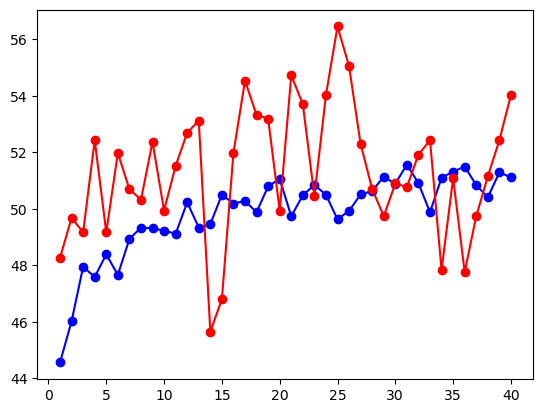

In [48]:
model = BertNLIModel(label_num=3, encoder_layer=5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [49]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9285592302984121
accuracy 0.5400874635568513
precision 0.5400874635568513
recall 0.5400874635568513
f1 0.5400874635568513
[[261 158  91]
 [185 290  44]
 [187  54 294]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-6-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[15s] Epoch 1 loss : 1.04609971 acc: 44.3 val: 1.01235170 acc: 48.72%


### BETTER NET STATE ###
[15s] Epoch 2 loss : 1.01694044 acc: 46.7 val: 0.99128732 acc: 47.31%


### BETTER NET STATE ###
[15s] Epoch 3 loss : 0.99813203 acc: 49.0 val: 0.97031333 acc: 52.81%


[15s] Epoch 4 loss : 1.00440120 acc: 48.43 val: 0.97148065 acc: 51.28%


### BETTER NET STATE ###
[15s] Epoch 5 loss : 0.99781750 acc: 48.42 val: 0.95749896 acc: 53.9%


### BETTER NET STATE ###
[15s] Epoch 6 loss : 0.98692648 acc: 49.79 val: 0.95307750 acc: 53.77%


[15s] Epoch 7 loss : 0.98060967 acc: 50.88 val: 1.05030279 acc: 44.69%


[15s] Epoch 8 loss : 0.99053735 acc: 49.55 val: 1.05545465 acc: 44.82%


### BETTER NET STATE ###
[15s] Epoch 9 loss : 0.98687731 acc: 49.85 val: 0.95141034 acc: 54.16%


### BETTER NET STATE ###
[15s] Epoch 10 loss : 0.98291478 acc: 49.79 val: 0.94584139 acc: 53.26%


[15s] Epoch 11 loss : 0.98390893 acc: 49.59 val: 0.95298694 acc: 53.52%


### BETTER NET STATE ###
[15s] Epoch 12 loss : 0.97884383 acc: 50.44 val: 0.94193416 acc: 54.28%


[15s] Epoch 13 loss : 0.97564985 acc: 50.87 val: 0.98489663 acc: 49.23%


[15s] Epoch 14 loss : 0.97670666 acc: 51.43 val: 0.94535595 acc: 52.17%


[15s] Epoch 15 loss : 0.97989577 acc: 49.46 val: 0.95694732 acc: 51.34%


[15s] Epoch 16 loss : 0.97716909 acc: 50.28 val: 0.95022356 acc: 51.73%


[15s] Epoch 17 loss : 0.96877774 acc: 51.64 val: 0.95236308 acc: 53.52%


### BETTER NET STATE ###
[15s] Epoch 18 loss : 0.97591734 acc: 50.95 val: 0.93492685 acc: 55.31%


[15s] Epoch 19 loss : 0.96580087 acc: 51.78 val: 0.98770066 acc: 49.36%


[15s] Epoch 20 loss : 0.97578504 acc: 50.87 val: 0.93812529 acc: 55.18%


### BETTER NET STATE ###
[15s] Epoch 21 loss : 0.96951287 acc: 51.5 val: 0.92643901 acc: 56.14%


[15s] Epoch 22 loss : 0.96857534 acc: 51.5 val: 0.97855728 acc: 48.59%


[15s] Epoch 23 loss : 0.97311205 acc: 51.12 val: 0.94185766 acc: 53.26%


[15s] Epoch 24 loss : 0.96575305 acc: 51.84 val: 0.92907979 acc: 54.92%


[15s] Epoch 25 loss : 0.96623288 acc: 51.54 val: 0.99070038 acc: 47.57%


[15s] Epoch 26 loss : 0.97798079 acc: 50.78 val: 0.93649702 acc: 54.03%


### BETTER NET STATE ###
[15s] Epoch 27 loss : 0.96637977 acc: 51.28 val: 0.92481530 acc: 55.69%


[15s] Epoch 28 loss : 0.97073677 acc: 51.76 val: 0.92858783 acc: 56.33%


[15s] Epoch 29 loss : 0.96805945 acc: 51.61 val: 0.93079052 acc: 55.05%


 78%|███████▊  | 176/227 [00:09<00:02, 18.36it/s, epoch=30, phase=train, loss=0.9608]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[15s] Epoch 37 loss : 0.97227197 acc: 51.32 val: 0.93319112 acc: 53.2%


[15s] Epoch 38 loss : 0.96334316 acc: 52.24 val: 0.98592989 acc: 48.34%


### BETTER NET STATE ###
[15s] Epoch 39 loss : 0.95940841 acc: 52.46 val: 0.92140088 acc: 56.91%


[15s] Epoch 40 loss : 0.96634184 acc: 51.86 val: 0.93101693 acc: 54.6%


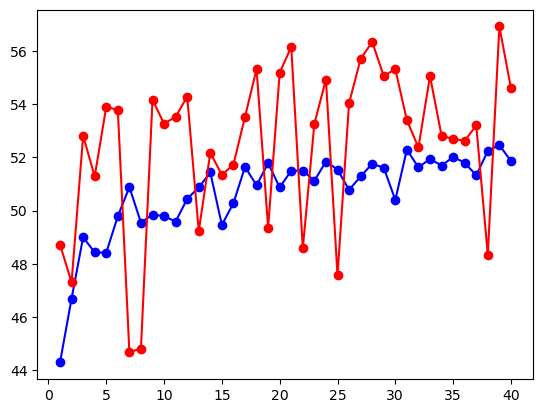

In [50]:
model = BertNLIModel(label_num=3, encoder_layer=6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [51]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9303889140790823
accuracy 0.5458272594752187
precision 0.5458272594752187
recall 0.5458272594752187
f1 0.5458272594752187
[[218 212  80]
 [125 355  39]
 [172  82 281]]
